## Installs

In [ ]:
!sudo apt install tree

## Imports

In [ ]:
import os
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np

# PlantVillage Dataset

**Name**: PlantVillage Dataset

**Dataset Links**:
   - Kaggle - https://www.kaggle.com/datasets/emmarex/plantdisease
   - PapersWithCode - https://paperswithcode.com/dataset/plantvillage
   - Mendeley - https://data.mendeley.com/datasets/tywbtsjrjv/1*

**Paper**: Identification of Plant Leaf Diseases Using a 9-layer Deep Convolutional Neural Network - https://doi.org/10.1016/j.compeleceng.2019.04.011

\* Our choise.

## Loading Dataset



In [ ]:
# create directory for dataset
!mkdir -p ./data

# download and unzip dataset
!wget -O ./data/plantvillage.zip https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded
!unzip ./data/plantvillage.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (132).JPG  
  inflating: ./data/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1320).JPG  
  inflating: ./data/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1321).JPG  
  inflating: ./data/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1322).JPG  
  inflating: ./data/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1323).JPG  
  inflating: ./data/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1324).JPG  
  inflating: ./data/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1325).JPG  
  inflating: ./data/Plant_leave_diseases_dataset_witho

In [ ]:
# set dataset directory
data_dir = '/content/data/Plant_leave_diseases_dataset_without_augmentation'

## Classes

The following 39 classes are availaible in the dataset. The images for each class are in their respectively named class directory.

In [ ]:
!tree -d /content/data/Plant_leave_diseases_dataset_without_augmentation

/content/data/Plant_leave_diseases_dataset_without_augmentation
├── Apple___Apple_scab
├── Apple___Black_rot
├── Apple___Cedar_apple_rust
├── Apple___healthy
├── Background_without_leaves
├── Blueberry___healthy
├── Cherry___healthy
├── Cherry___Powdery_mildew
├── Corn___Cercospora_leaf_spot Gray_leaf_spot
├── Corn___Common_rust
├── Corn___healthy
├── Corn___Northern_Leaf_Blight
├── Grape___Black_rot
├── Grape___Esca_(Black_Measles)
├── Grape___healthy
├── Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
├── Orange___Haunglongbing_(Citrus_greening)
├── Peach___Bacterial_spot
├── Peach___healthy
├── Pepper,_bell___Bacterial_spot
├── Pepper,_bell___healthy
├── Potato___Early_blight
├── Potato___healthy
├── Potato___Late_blight
├── Raspberry___healthy
├── Soybean___healthy
├── Squash___Powdery_mildew
├── Strawberry___healthy
├── Strawberry___Leaf_scorch
├── Tomato___Bacterial_spot
├── Tomato___Early_blight
├── Tomato___healthy
├── Tomato___Late_blight
├── Tomato___Leaf_Mold
├── Tomato___Septori

## Loading and Splitting Dataset

In [ ]:
# set random states
random_seed = 49
torch.manual_seed(random_seed)

# load entire dataset
dataset = datasets.ImageFolder(root=data_dir)

# get indicies and labes for all examples
indices = list(range(len(dataset)))
labels = [dataset.targets[i] for i in indices]

# splitting
train_indices, temp_indices, train_labels, temp_labels = train_test_split(
    indices,
    labels,
    test_size=0.3,
    stratify=labels,
    random_state=random_seed
)

val_indices, test_indices, val_labels, test_labels = train_test_split(
    temp_indices,
    temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=random_seed
)

In [ ]:
# save split indicies
np.save('train_indices.npy', train_indices)
np.save('val_indices.npy', val_indices)
np.save('test_indices.npy', test_indices)

## Data Transformations

To comply with the requirments for the DenseNet architecture we must perform normailization for the dataset images.

We apply data augmentation and normalization to the train split and only normalization the validation (test and val) test splits

In [ ]:
# define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# apply transformations to dataset
train_transformed_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
val_test_transformed_dataset = datasets.ImageFolder(root=data_dir, transform=val_test_transform)

# split datasets
train_subset = Subset(train_transformed_dataset, train_indices)
val_subset = Subset(val_test_transformed_dataset, val_indices)
test_subset = Subset(val_test_transformed_dataset, test_indices)

print(f'Total samples: {len(dataset)}')
print(f'Training samples: {len(train_subset)}')
print(f'Validation samples: {len(val_subset)}')
print(f'Test samples: {len(test_subset)}')

Total samples: 55448
Training samples: 38813
Validation samples: 8317
Test samples: 8318


## Visualizing Dataset Splits

Based on our splitting method using stratification, the class distributions in each split should be similar. This is a crucial point for effective training and validation.

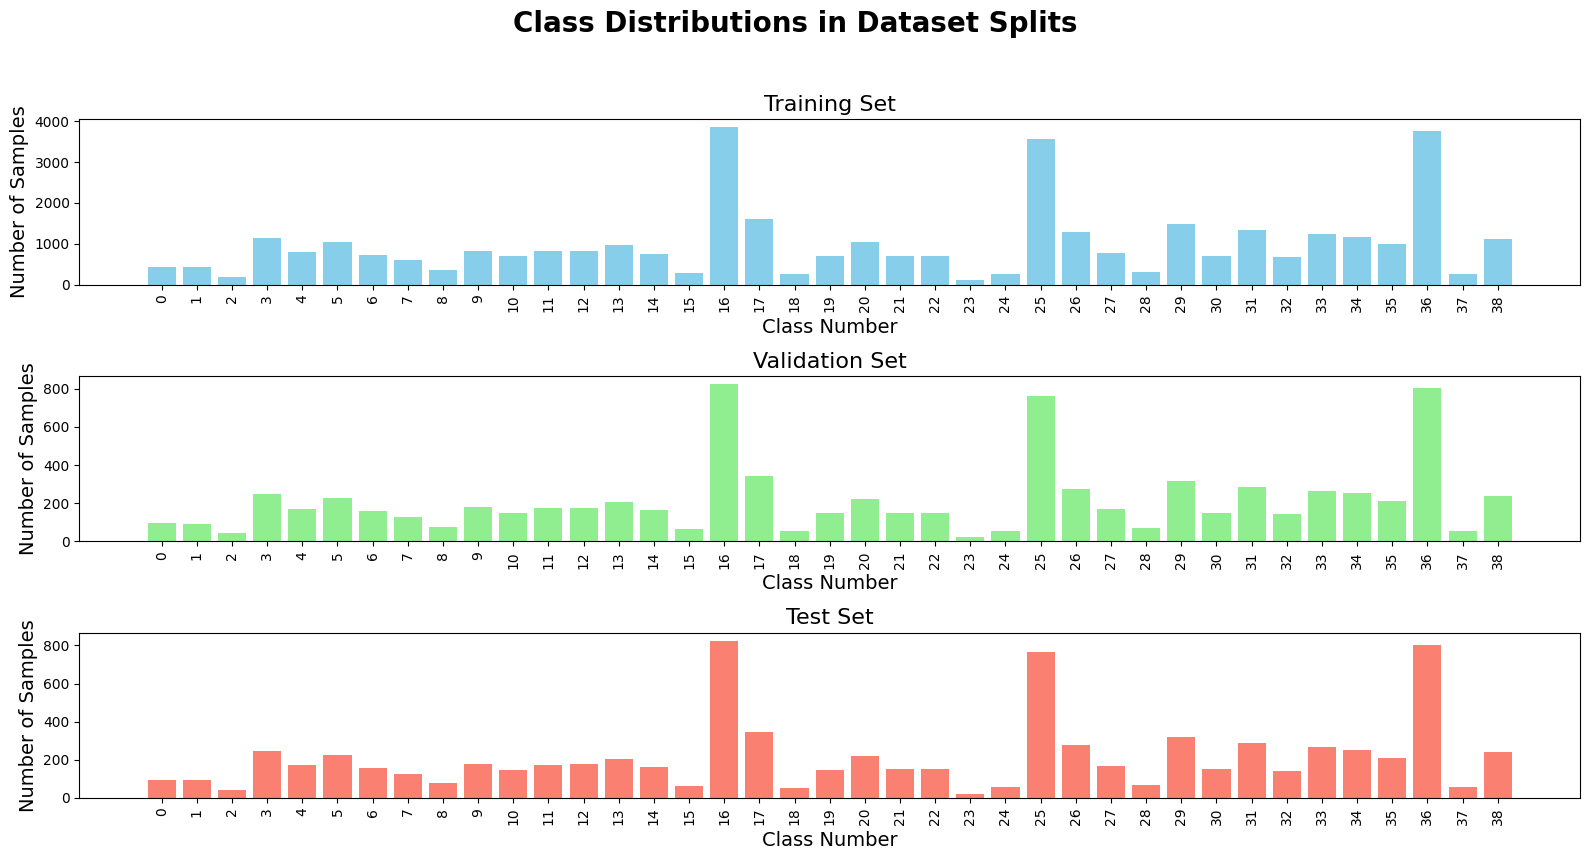

In [ ]:
# use label numbers instead of names
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
test_counts = Counter(test_labels)

# list of class numbers
class_numbers = list(range(len(dataset.classes)))

# count class instances in each split
train_counts_ordered = [train_counts.get(i, 0) for i in class_numbers]
val_counts_ordered = [val_counts.get(i, 0) for i in class_numbers]
test_counts_ordered = [test_counts.get(i, 0) for i in class_numbers]

# plotting distributions in 3x1 grid
fig, axes = plt.subplots(3, 1, figsize=(16, 9))
fig.suptitle('Class Distributions in Dataset Splits', fontsize=20, fontweight='bold')

colors = ['skyblue', 'lightgreen', 'salmon']

axes[0].bar(class_numbers, train_counts_ordered, color=colors[0])
axes[0].set_title('Training Set', fontsize=16)
axes[0].set_xlabel('Class Number', fontsize=14)
axes[0].set_ylabel('Number of Samples', fontsize=14)
axes[0].set_xticks(class_numbers)
axes[0].set_xticklabels(class_numbers, rotation=90)

axes[1].bar(class_numbers, val_counts_ordered, color=colors[1])
axes[1].set_title('Validation Set', fontsize=16)
axes[1].set_xlabel('Class Number', fontsize=14)
axes[1].set_ylabel('Number of Samples', fontsize=14)
axes[1].set_xticks(class_numbers)
axes[1].set_xticklabels(class_numbers, rotation=90)

axes[2].bar(class_numbers, test_counts_ordered, color=colors[2])
axes[2].set_title('Test Set', fontsize=16)
axes[2].set_xlabel('Class Number', fontsize=14)
axes[2].set_ylabel('Number of Samples', fontsize=14)
axes[2].set_xticks(class_numbers)
axes[2].set_xticklabels(class_numbers, rotation=90)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Visualizing Training Samples


In [ ]:
# function to display images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # denormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

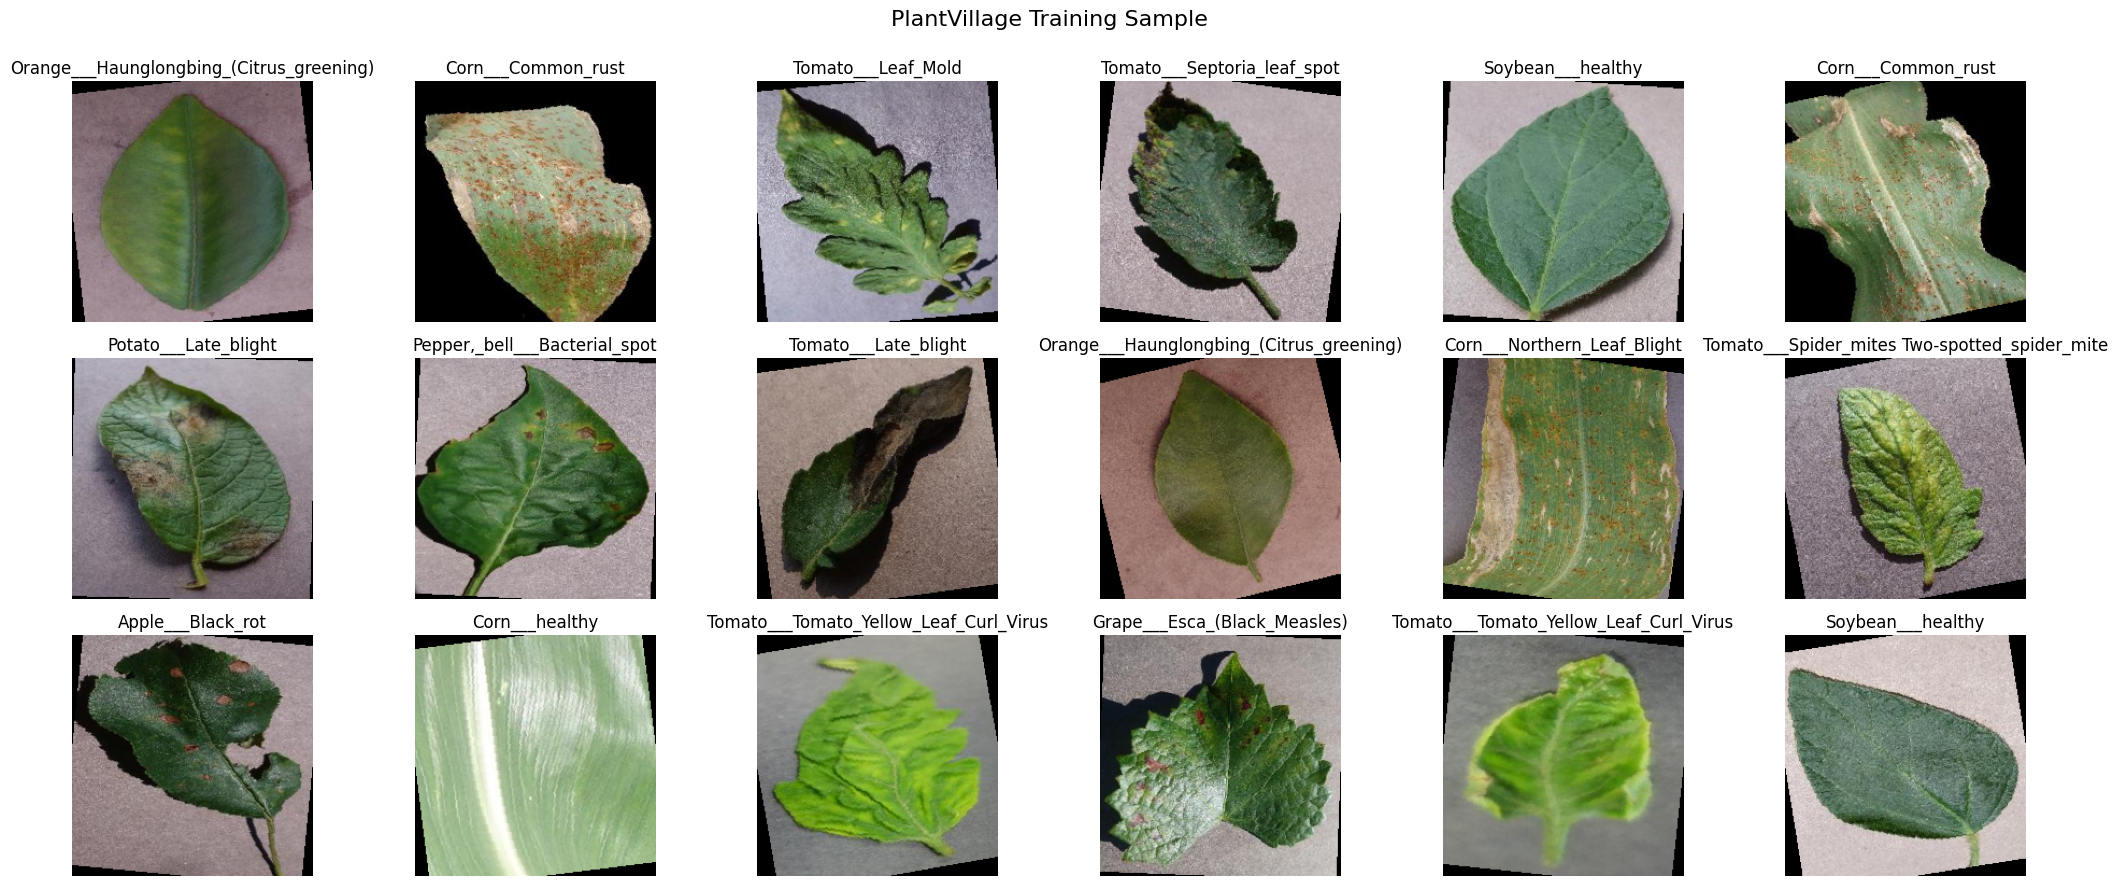

In [ ]:
# get class names
class_names = dataset.classes

# create DataLoader to sample from training subset
sample_dataloader = DataLoader(train_subset, batch_size=18, shuffle=True)

# get a batch of images
inputs, labels = next(iter(sample_dataloader))

# display in 3x6 grid
fig, axes = plt.subplots(3, 6, figsize=(21, 9))
fig.suptitle('PlantVillage Training Sample', fontsize=16)

for idx in range(18):
    ax = axes[idx // 6, idx % 6]
    plt.sca(ax)
    imshow(inputs[idx], title=class_names[labels[idx]])

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# DenseNet

**Paper**: Densely Connected Convolutional Networks - https://arxiv.org/abs/1608.06993

**Implementations**:
  - DenseNet Official Repo - https://github.com/liuzhuang13/DenseNet
  - Keras Applications - https://keras.io/api/applications/
  - Pytorch/TorchVision - https://pytorch.org/hub/pytorchvisiondensenet/*

\* Implementation we used (specifically 161 variant)

## Loading Model

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet161', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 127MB/s] 


## Model Summary

In [ ]:
input_size = (1, 3, 224, 224) # example input size
summary(model, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [1, 1000]                 --
├─Sequential: 1-1                        [1, 2208, 7, 7]           --
│    └─Conv2d: 2-1                       [1, 96, 112, 112]         14,112
│    └─BatchNorm2d: 2-2                  [1, 96, 112, 112]         192
│    └─ReLU: 2-3                         [1, 96, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 96, 56, 56]           --
│    └─_DenseBlock: 2-5                  [1, 384, 56, 56]          --
│    │    └─_DenseLayer: 3-1             [1, 48, 56, 56]           101,952
│    │    └─_DenseLayer: 3-2             [1, 48, 56, 56]           111,264
│    │    └─_DenseLayer: 3-3             [1, 48, 56, 56]           120,576
│    │    └─_DenseLayer: 3-4             [1, 48, 56, 56]           129,888
│    │    └─_DenseLayer: 3-5             [1, 48, 56, 56]           139,200
│    │    └─_DenseLayer: 3-6             [1, 48, 56, 56

# Training and Evaluation

*Training and evaluation are conducted on a separate notebook*
